# Importing Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV,train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import warnings
import time
import pickle

# Downloading and Analysing Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("akshaydattatraykhare/diabetes-dataset")

In [ ]:
df = pd.read_csv(f'{path}/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.duplicated().sum().sum()

0

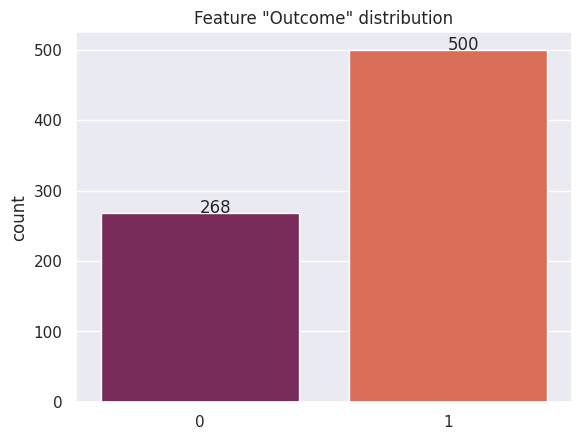

In [ ]:
sns.set_theme(style='darkgrid')
ax = sns.barplot(x=df['Outcome'].unique(),y=df['Outcome'].value_counts(),palette='rocket',hue=df['Outcome'].unique(),legend=False)
ax.set_title('Feature "Outcome" distribution')
for p in ax.patches:
  _x = p.get_x() + p.get_width() - 0.4
  _y = p.get_y() + p.get_height()
  value = int(p.get_height())
  ax.text(_x,_y,value,ha='left')
plt.show()

In [ ]:
X = df.drop(['Outcome'],axis=1).values
y = df['Outcome'].values

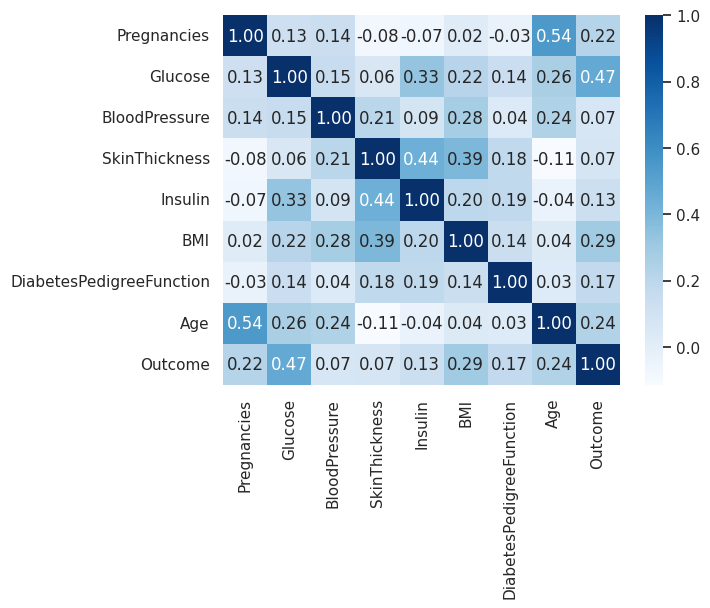

In [ ]:
sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap='Blues')
plt.show()

# Searching for Best Features

## RandomForestRegressor Method

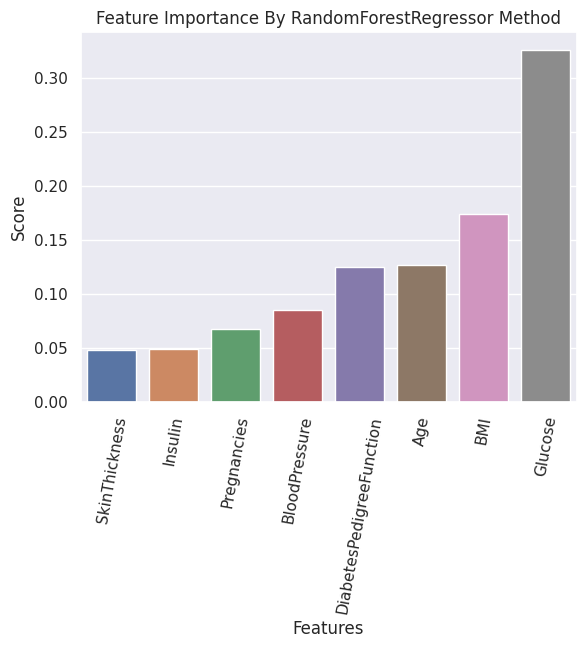

In [ ]:
from sklearn.ensemble import RandomForestRegressor
randomReg = RandomForestRegressor(random_state=5)
randomReg.fit(X,y)
feature_series = pd.Series(
    data=randomReg.feature_importances_,
    index = df.drop(['Outcome'],axis=1).columns
).sort_values()
sns.set_theme(style='darkgrid')
ax = sns.barplot(x=feature_series.index,y=feature_series.values,hue=feature_series.index,legend=False)
ax.set_title('Feature Importance By RandomForestRegressor Method')
ax.set_xlabel('Features')
ax.set_ylabel('Score')
plt.xticks(rotation=80)
plt.show()

## RFE Method

In [ ]:
from sklearn.feature_selection import RFE
RFE_model = RFE (RandomForestRegressor(random_state=5))
RFE_model.fit(X,y)

RFE(estimator=RandomForestRegressor(random_state=5))

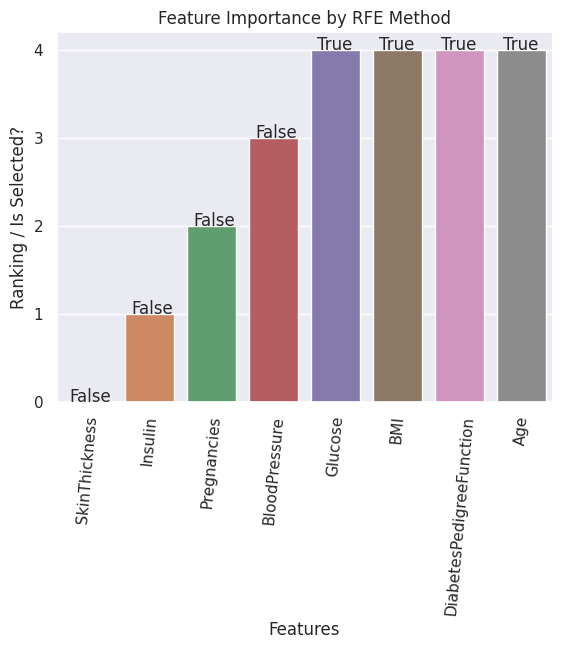

In [ ]:
features_dataframe = pd.DataFrame(
    data = {
        'ranking':max(RFE_model.ranking_) - RFE_model.ranking_,
        'isSelected':RFE_model.support_
    },
    index = df.drop(['Outcome'],axis=1).columns
)
features_dataframe.sort_values(by='ranking',inplace=True)
sns.set_theme(style='darkgrid')
ax = sns.barplot(x=features_dataframe.index,y=features_dataframe['ranking'].values,hue=features_dataframe.index,legend=False)
ax.set_title('Feature Importance by RFE Method')
ax.set_xlabel('Features')
ax.set_ylabel('Ranking / Is Selected?')
index = 0
for p in ax.patches:
  _x = p.get_x() + p.get_width() -0.7
  _y = p.get_y() + p.get_height()
  value = features_dataframe['isSelected'].iloc[index]
  ax.text(_x,_y,value,ha='left')
  index += 1
plt.xticks(rotation=85)
plt.yticks(ticks=range(0,max(RFE_model.ranking_)))
plt.show()

Both methods identified GLUCOSE, BMI, AGE, and DIABETESPEDIGREEFUNCTION as the best features

# Defining Train and Test Functions

In [ ]:
X_best_features = df[['Age','DiabetesPedigreeFunction','BMI','Glucose']].values
algs_dataframe = pd.DataFrame(
    index = ['KNN', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LinearDiscriminantAnalysis','NaiveBayes'],
    columns= ['Accuracy','Roc_Auc']
)
algs_dataframe

,Accuracy,Roc_Auc
KNN,NaN,NaN
LogisticRegression,NaN,NaN
RandomForest,NaN,NaN
XGBoost,NaN,NaN
LinearDiscriminantAnalysis,NaN,NaN
NaiveBayes,NaN,NaN
SVC,NaN,NaN


In [ ]:
def train_and_get_best_params(estimator,params,X,y,feature_transform=None):

  match feature_transform:
    case 'Standard':
      X = StandardScaler().fit_transform(X,y)
    case 'MinMax':
      X = MinMaxScaler().fit_transform(X,y)

  cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=5)
  random_search = RandomizedSearchCV(
      estimator = estimator,
      param_distributions=params,
      cv=cv,
      random_state=5
  )
  T0 = time.time()
  random_search.fit(X,y)
  T1 = time.time()
  print(f'Best Score:{random_search.best_score_*100:.2f}%')
  print(f'Time: {T1 - T0:.2f}')
  return random_search.best_params_

In [ ]:
def train_and_test_best_model(estimator,X,y,feature_transform=None):

  match feature_transform:
    case 'Standard':
      X = StandardScaler().fit_transform(X,y)
    case 'MinMax':
      X = MinMaxScaler().fit_transform(X,y)

  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=5)
  final_estimator = estimator.fit(X_train,y_train)
  preds = final_estimator.predict(X_test)
  accuracy = float(f'{accuracy_score(y_test,preds)*100:.2f}')
  roc_auc = float(f'{roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1])*100:.2f}')
  print(f'accuracy_score: {accuracy}%')
  print(f'roc_auc_score: {roc_auc}%')
  return accuracy, roc_auc

# Training and Evalutating Models

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
params = {
    'n_neighbors':range(3,10),
    'weights':['uniform','distance'],
    'algorithm':['ball_tree','kd_tree','brute']
}
best_params = train_and_get_best_params(KNeighborsClassifier(),params,X_best_features,y,feature_transform='Standard')

Best Score:77.08%
Time: 0.79


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
final_KNN = KNeighborsClassifier(**best_params)
values = train_and_test_best_model(final_KNN,X_best_features,y,feature_transform='Standard')
algs_dataframe.loc['KNN'] = values

accuracy_score: 76.62%
roc_auc_score: 84.12%


# Logistic Regression

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LogisticRegression
params = {
    'penalty':['none','l2','l1','elasticnet'],
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
    'C':np.logspace(-3,3,7)
}
best_params = train_and_get_best_params(LogisticRegression(),params,X,y)

Best Score:77.60%
Time: 2.26


In [ ]:
final_LR = LogisticRegression(**best_params)
values = train_and_test_best_model(final_LR,X,y)
algs_dataframe.loc['LogisticRegression'] = values

accuracy_score: 80.52%
roc_auc_score: 86.26%


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'n_estimators':range(100,500,50),
    'criterion':['gini','entropy','log_loss'],
    'random_state':[5]
}
best_params = train_and_get_best_params(RandomForestClassifier(),params,X,y)

Best Score:78.38%
Time: 71.57


In [ ]:
final_RF = RandomForestClassifier(**best_params)
values = train_and_test_best_model(final_RF,X,y)
algs_dataframe.loc['RandomForest'] = values

accuracy_score: 77.27%
roc_auc_score: 86.69%


# XGBoost

In [ ]:
from xgboost import XGBClassifier
params = {
    'learning_rate':np.logspace(-3,3,7),
    'max_depth':range(3,7),
    'subsample':[0.1,0.15,0.5,1],
    'n_estimators':range(100,560,50),
    'objective':['binary:logistic']
}
best_params = train_and_get_best_params(XGBClassifier(),params,X,y)

Best Score:76.29%
Time: 11.89


In [ ]:
final_XGB = XGBClassifier(**best_params)
values = train_and_test_best_model(final_XGB,X,y)
algs_dataframe.loc['XGBoost'] = values

accuracy_score: 81.82%
roc_auc_score: 88.57%


# Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
params = {
    'solver':['svd','lsqr','eigen'],
    'shrinkage':[0.001,0.01,0.1,1]
}
best_params = train_and_get_best_params(LinearDiscriminantAnalysis(),params,X_best_features,y,feature_transform='MinMax')

Best Score:77.60%
Time: 0.33


In [ ]:
final_LDA = LinearDiscriminantAnalysis(**best_params)
values = train_and_test_best_model(final_LDA,X_best_features,y,feature_transform='MinMax')
algs_dataframe.loc['LinearDiscriminantAnalysis'] = values

accuracy_score: 80.52%
roc_auc_score: 86.76%


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
final_GNB = GaussianNB()
values = train_and_test_best_model(final_GNB,X,y,feature_transform='Standard')
algs_dataframe.loc['NaiveBayes'] = values

accuracy_score: 76.62%
roc_auc_score: 85.07%


# Analysing Algs and Saving Models

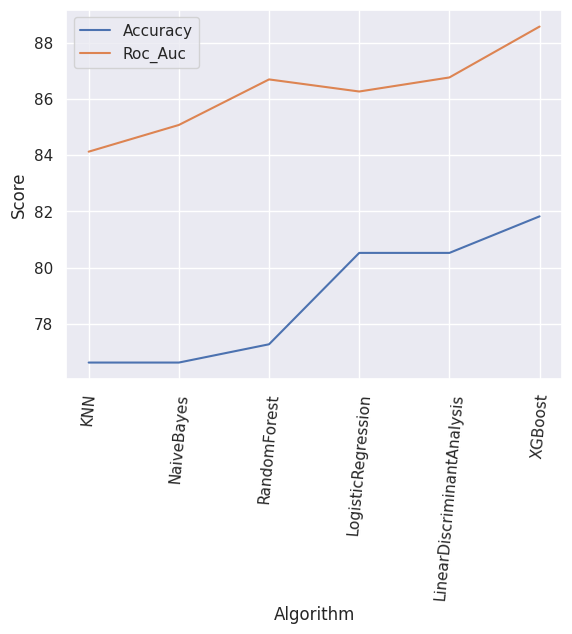

In [ ]:
algs_dataframe.sort_values(by='Accuracy',inplace=True)
ax = algs_dataframe.plot()
ax.set_xlabel('Algorithm')
ax.set_ylabel("Score")
plt.xticks(rotation=85)
plt.show()

In [66]:
pickle.dump(final_KNN,open('KNN.pkl','wb'))
pickle.dump(final_LR,open('LR.pkl','wb'))
pickle.dump(final_RF,open('RF.pkl','wb'))
pickle.dump(final_XGB,open('XGB.pkl','wb'))
pickle.dump(final_LDA,open('LDA.pkl','wb'))
pickle.dump(final_GNB,open('GNB.pkl','wb'))